# XPCS&XSVS Pipeline for Setup of (Gi)-SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Compress Data
* Define Q-ROI, e.g. qr for SAXS, (qr, qz) for gi-saxs

The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Load Packages

Import packages for I/O, visualization, and analysis.

In [1]:
from pyCHX.chx_packages import *
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams.update({ 'image.origin': 'lower'   })
plt.rcParams.update({ 'image.interpolation': 'none'   })
import pickle as cpk
from pyCHX.chx_xpcs_xsvs_jupyter_V1 import *
from skimage.draw import line_aa, line, polygon, ellipse

In [2]:
%matplotlib notebook

In [3]:
#%matplotlib inline

# Define Scattering Geometry Here

In [4]:
scat_geometry = 'saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_saxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
#scat_geometry = 'gi_waxs'  #suport 'saxs', 'gi_saxs', 'ang_saxs' (for anisotropics saxs or flow-xpcs)
                           # gi_waxs define a simple box-shaped ROI 
qphi_analysis = False #True  #if True, do q-phi analysis in case of SAXS
flow=False
force_compress = False 
single_image = True #take one image for make ROI



# Define Result Save Folder

In [5]:
CYCLE= '2019_3'  #change clycle here
username =  getpass.getuser()
#username = 'commissioning'


path = '/XF11ID/analysis/%s/masks/'%CYCLE
data_dir0  = create_user_folder(CYCLE, username)
print( data_dir0 )

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_3/yuzhang/Results/
/XF11ID/analysis/2019_3/yuzhang/Results/


## Load Metadata & Image Data

In [6]:
#uid = '0b97b253' #(scan num: 17044 (Measurement: Series 0.000112s X 5000 -sample: N1: NP250, Stock xh=0.5 yh=1.894 Series 0.000112s X 5000 -sample: N1: NP250, Stock 
uid = '8bd61365' #(scan num: 17046 (Measurement: Series 0.00134s X 1000 -sample: N1: NP250, Stock xh=0.5 yh=1.794 Series 0.00134s X 1000 -sample: N1: NP250, Stock



In [7]:
#get_last_uids( -1 )

In [8]:
data_dir = os.path.join(data_dir0, '%s/'%uid)
os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)
uidstr = 'uid=%s'%uid

Results from this analysis will be stashed in the directory /XF11ID/analysis/2019_3/yuzhang/Results/8bd61365/


In [9]:
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

filepath : /nsls2/xf11id1/data/2019/06/26/36481584-af96-4d2f-9c5c
got images_per_file
scan_id, full-uid, data path are:  17046--8bd61365-acd4-4f3e-9eb6-eb6b9a35dfe6--/XF11ID/data/2019/06/26/45f87b0e-807a-423b-a27b_000000.tiff


In [10]:
#%run /home/yuzhang/pyCHX_link/pyCHX/chx_generic_functions.py

In [11]:
md = get_meta_data( uid )
if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    reverse= True
    rot90= False
elif md['detector'] =='eiger500K_single_image':    
    reverse= True
    rot90=True
elif md['detector'] =='eiger1m_single_image':    
    reverse= True
    rot90=False

More than one device. This would have unintented consequences.Currently, only the device contains 'default_dec=eiger'.


In [12]:

imgs = load_data( uid, md['detector'], reverse= reverse, rot90=rot90  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

#md['acquire period' ] = md['cam_acquire_period']
#md['exposure time'] =  md['cam_acquire_time']
mdn = md.copy()

/opt/conda_envs/analysis-2019-1.2-chx/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


The data are: Pipeline processed through proc_func. Original repr:
    EigerImages processed through proc_func. Original repr:
        <Frames>
        Length: 1000 frames
        Frame Shape: 2167 x 2070
        Pixel Datatype: uint16


In [13]:
print_dict( md,  ['suid', 'number of images', 'uid', 'scan_id', 'start_time', 'stop_time', 'sample', 'Measurement',
                  'acquire period', 'exposure time',  
         'det_distance', 'beam_center_x', 'beam_center_y', ] )

suid--> 8bd61365
number of images--> 1000
uid--> 8bd61365-acd4-4f3e-9eb6-eb6b9a35dfe6
scan_id--> 17046
start_time--> 2019-06-26 13:03:58
stop_time--> 2019-06-26 13:04:34
sample--> N1: NP250, Stock
Measurement--> Series 0.00134s X 1000 -sample: N1: NP250, Stock xh=0.5 yh=1.794 Series 0.00134s X 1000 -sample: N1: NP250, Stock
acquire period--> 0.00134
exposure time--> 0.00134
beam_center_x--> 1128.0
beam_center_y--> 1234.0


### Define incident beam center (also define reflection beam center for gisaxs)

In [14]:
if scat_geometry =='gi_saxs':
    inc_x0 =  md['beam_center_x'] 
    inc_y0 =  imgs[0].shape[0] - md['beam_center_y']     
    refl_x0 =     md['beam_center_x']  
    refl_y0 =     1000     #imgs[0].shape[0] -  1758  
    
    print( "inc_x0, inc_y0, ref_x0,ref_y0 are: %s %s %s %s."%(inc_x0, inc_y0, refl_x0, refl_y0) )
else:
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image' or md['detector']=='eiger1m_single_image':    
        inc_x0 =  imgs[0].shape[0] - md['beam_center_y']   
        inc_y0=   md['beam_center_x']
    elif md['detector'] =='eiger500K_single_image':    
        inc_y0 =  imgs[0].shape[1] - md['beam_center_y']   
        inc_x0 =   imgs[0].shape[0] - md['beam_center_x']
    
    print(inc_x0, inc_y0)
    ###for this particular uid, manually give x0/y0
    #inc_x0 = 1041
    #inc_y0 = 1085

933.0 1128.0


In [15]:
dpix, lambda_, Ldet,  exposuretime, timeperframe, center = check_lost_metadata(
    md, Nimg, inc_x0 = inc_x0, inc_y0=   inc_y0, pixelsize = 7.5*10*(-5) )
if scat_geometry =='gi_saxs':center=center[::-1]
setup_pargs=dict(uid=uidstr, dpix= dpix, Ldet=Ldet, lambda_= lambda_, exposuretime=exposuretime,
        timeperframe=timeperframe, center=center, path= data_dir)
print_dict( setup_pargs )
mdn['beam_center_x'], mdn['beam_center_y'] = center[::-1]

Beam_center_x has been changed to 1128.0. (no change in raw metadata): 
Beam_center_y has been changed to 933.0.  (no change in raw metadata): 
uid--> uid=8bd61365
dpix--> 0.07500000356230885
Ldet--> 16035.699844360352
lambda_--> 1.2846771
exposuretime--> 0.0013340212
timeperframe--> 0.00134
center--> [933, 1128]
path--> /XF11ID/analysis/2019_3/yuzhang/Results/8bd61365/


# Load Mask file

In [16]:
if scat_geometry == 'gi_saxs':
    mask_path = '/XF11ID/analysis/2019_1/masks/'    
    mask_name =  'Feb5_2018_4M.npy'
    
elif scat_geometry == 'saxs':
    mask_path = '/XF11ID/analysis/2019_2/masks/'
    if md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
        mask_name = 'June26_2019_4M_SAXS.npy'  
    elif md['detector'] =='eiger500K_single_image':    
        mask_name = 'June26_2019_500K_SAXS.npy'
        
elif scat_geometry == 'gi_waxs':    
    mask_path = '/XF11ID/analysis/2019_1/masks/'
    mask_name = 'July20_2018_1M_WAXS.npy'
    
    

In [17]:
if md['detector'] =='eiger1m_single_image':
    Chip_Mask=np.load( '/XF11ID/analysis/2017_1/masks/Eiger1M_Chip_Mask.npy')
elif md['detector'] =='eiger4m_single_image' or md['detector'] == 'image':    
    Chip_Mask= np.array(np.load( '/XF11ID/analysis/2017_1/masks/Eiger4M_chip_mask.npy'), dtype=bool)
    BadPix =     np.load('/XF11ID/analysis/2018_1/BadPix_4M.npy'  )  
    Chip_Mask.ravel()[BadPix] = 0
elif md['detector'] =='eiger500K_single_image':
    Chip_Mask=  np.load( '/XF11ID/analysis/2017_1/masks/Eiger500K_Chip_Mask.npy')  #to be defined the chip mask
    Chip_Mask = np.rot90(Chip_Mask)
    pixel_mask = np.rot90(  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool))   )
else:
    Chip_Mask = 1
#show_img(Chip_Mask)

<IPython.core.display.Javascript object>


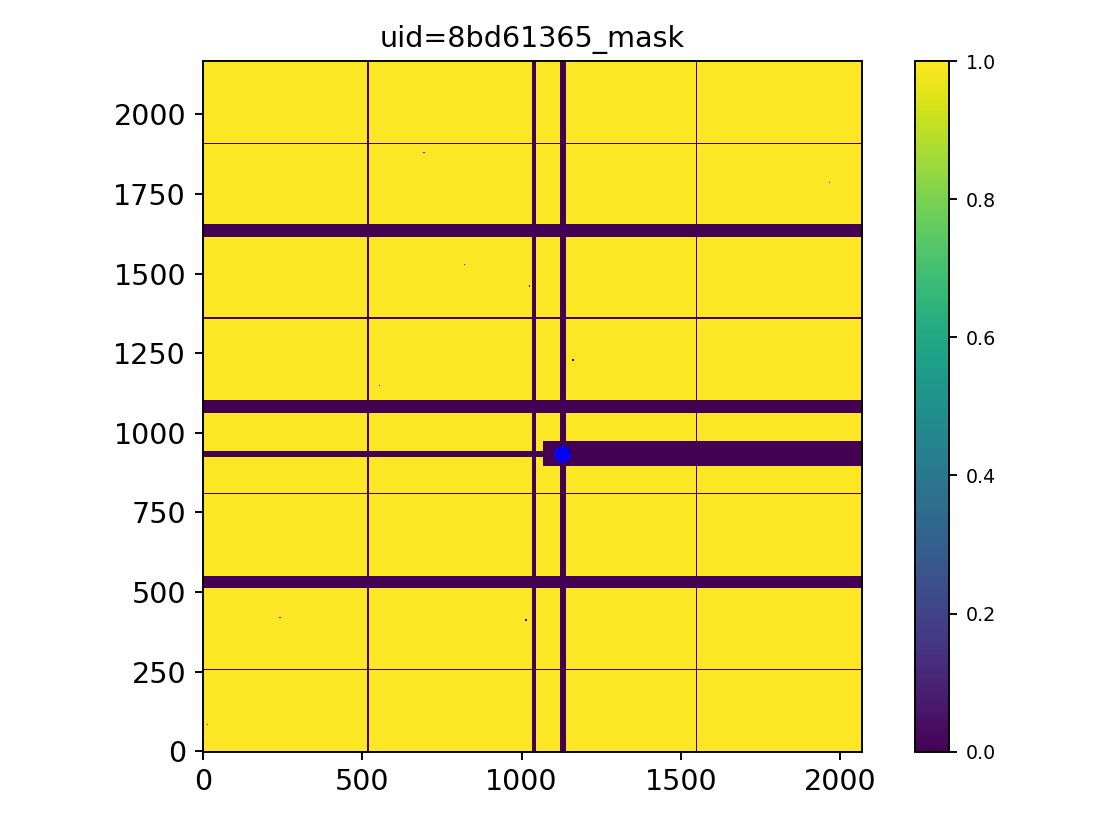

In [18]:
mask = load_mask(mask_path, mask_name, plot_ =  False, image_name = uidstr + '_mask', reverse= reverse, rot90=rot90  ) 
mask =  mask * pixel_mask * Chip_Mask
show_img(mask,image_name = uidstr + '_mask', save=True, path=data_dir, aspect=1, center=center[::-1])
mask_load=mask.copy()
imgsa = apply_mask( imgs, mask )

In [19]:
#%run /home/yuzhang/chxanalys_link/chxanalys/chx_generic_functions.py

<IPython.core.display.Javascript object>


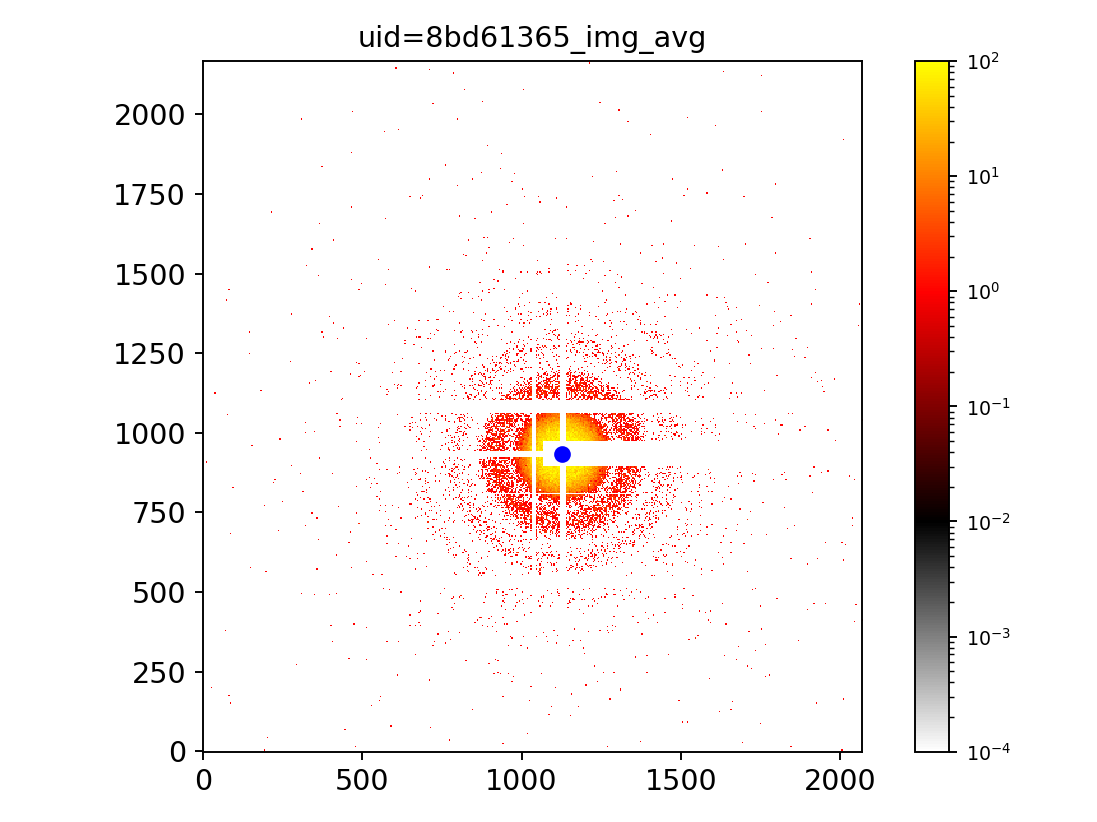

In [20]:
show_img( imgsa[0] ,  vmin=.0001, vmax= 1e2, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir,  cmap = cmap_albula, center=center[::-1] )

# Compress Data

In [21]:
good_start =0 #Usually we discard the first 5 files. The good_start could, however be 0 (no files discarded)

In [22]:
bin_frame = False #True # False # True  #generally make bin_frame as False
if bin_frame:
    bin_frame_number= 4
    timeperframe = acquisition_period * bin_frame_number
else:
    bin_frame_number =1

In [23]:
single_image= False #True #False #True

Using already created compressed file with filename as :/nsls2/xf11id1/analysis/Compressed_Data/uid_8bd61365-acd4-4f3e-9eb6-eb6b9a35dfe6.cmp.
The good_start frame number is: 0 
uid=8bd61365_fra_0_1000


<IPython.core.display.Javascript object>


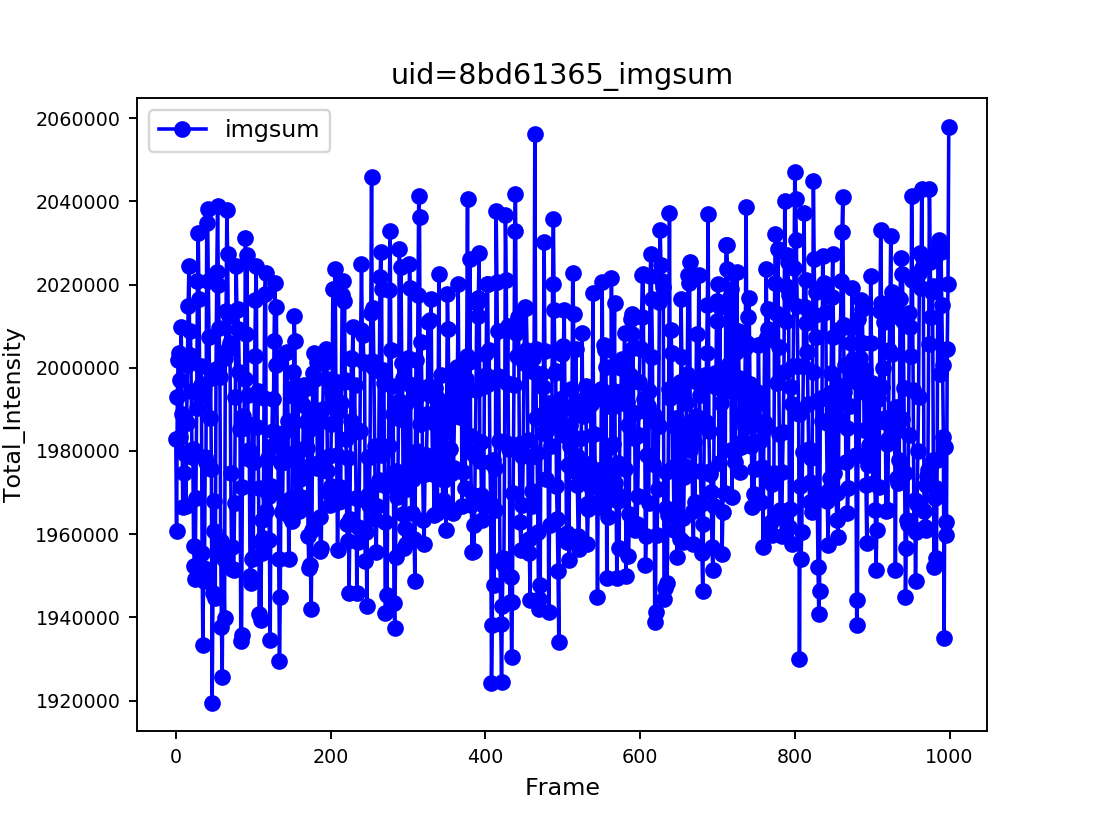

Total time: 0.805 sec


In [24]:
if not single_image:
    force_compress= False
    import time
    t0= time.time()
    use_local_disk = True
    para_compress = True
    sud = get_sid_filenames(db[uid])
    for pa in sud[2]:
        if 'master.h5' in pa:
            data_fullpath = pa
        
    if not use_local_disk:
        cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'
    else:
        cmp_path = '/tmp_data/compressed'

    cmp_path = '/nsls2/xf11id1/analysis/Compressed_Data'    
    if bin_frame_number==1:   
        cmp_file = '/uid_%s.cmp'%md['uid']
    else:
        cmp_file = '/uid_%s_bined--%s.cmp'%(md['uid'],bin_frame_number)

    filename = cmp_path + cmp_file   
    mask2, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
             force_compress= force_compress,  para_compress= para_compress,  bad_pixel_threshold = 1e14,
                                        reverse=reverse, rot90=rot90,
                            bins=bin_frame_number, num_sub= 100, num_max_para_process= 500, with_pickle=True,
                            direct_load_data =use_local_disk, data_path = data_fullpath, )  

    min_inten = 10    
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
    print ('The good_start frame number is: %s '%good_start)
    FD = Multifile(filename, good_start, len(imgs)//bin_frame_number)
    #FD = Multifile(filename, good_start, 100)
    uid_ = uidstr + '_fra_%s_%s'%(FD.beg, FD.end)
    print( uid_ )
    plot1D( y = imgsum[ np.array( [i for i in np.arange(good_start, len(imgsum)) if i not in bad_frame_list])],
           title =uidstr + '_imgsum', xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )
    Nimg = Nimg/bin_frame_number
    run_time(t0)
else:
    avg_img = imgsa[0]

mask =  mask * pixel_mask * Chip_Mask
mask_copy = mask.copy()


# Show the average image

<IPython.core.display.Javascript object>


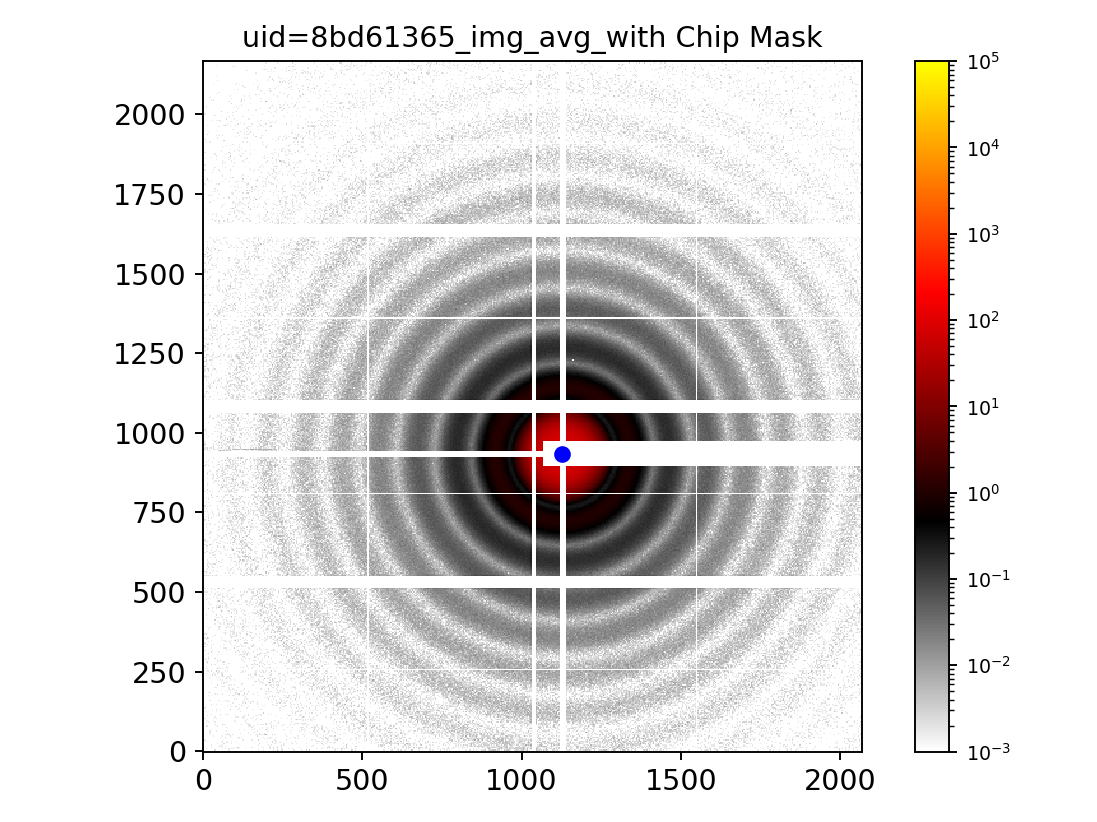

In [25]:
show_img( avg_img * Chip_Mask *mask,  vmin=1e-3, vmax= 1e5, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg_with Chip Mask',  save=True, path=data_dir, center=center[::-1], cmap = cmap_albula )

<IPython.core.display.Javascript object>


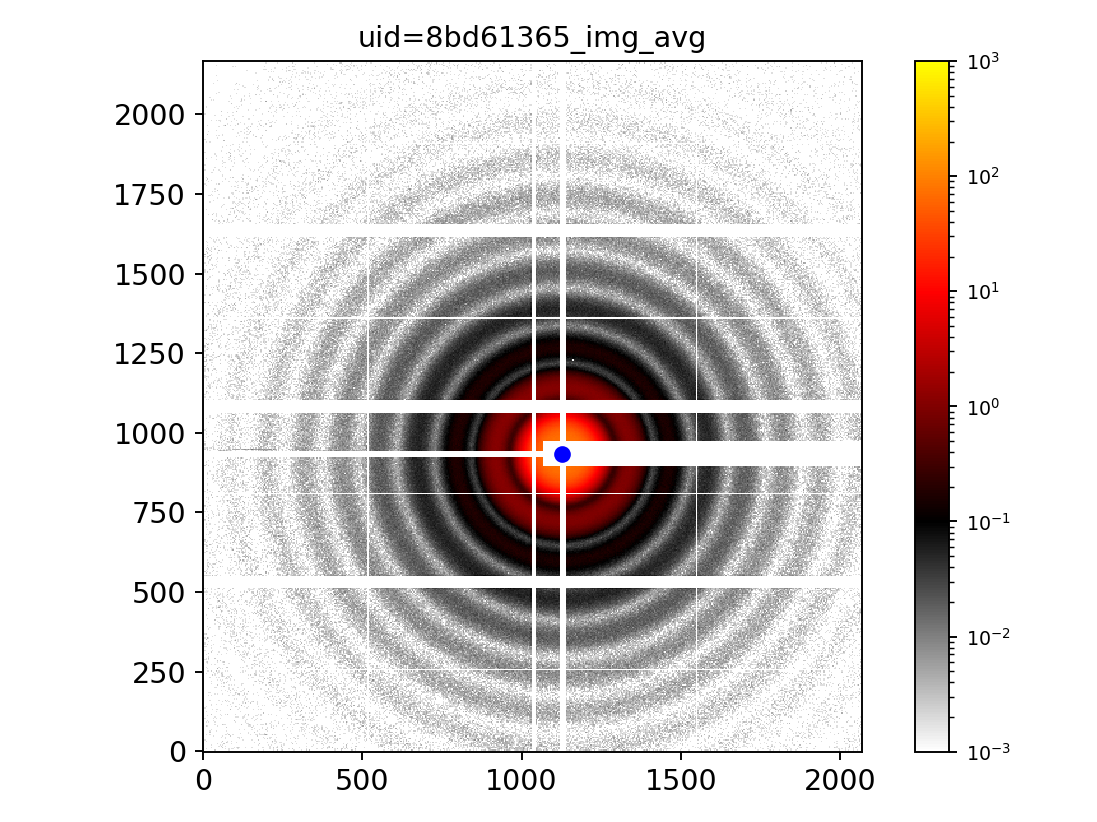

In [26]:
show_img( avg_img *mask ,  vmin=1e-3, vmax= 1e3, logs=True, aspect=1, #save_format='tif',
         image_name= uidstr + '_img_avg',  save=True, path=data_dir, center=center[::-1], cmap = cmap_albula )

# Define ROI Depending on Scattering Geometry

## SAXS Scattering Geometry

In [27]:
setup_pargs 

{'uid': 'uid=8bd61365',
 'dpix': 0.07500000356230885,
 'Ldet': 16035.699844360352,
 'lambda_': 1.2846771,
 'exposuretime': 0.0013340212,
 'timeperframe': 0.00134,
 'center': [933, 1128],
 'path': '/XF11ID/analysis/2019_3/yuzhang/Results/8bd61365/'}

In [28]:
#np.where(hmask.ravel()==0)

<IPython.core.display.Javascript object>


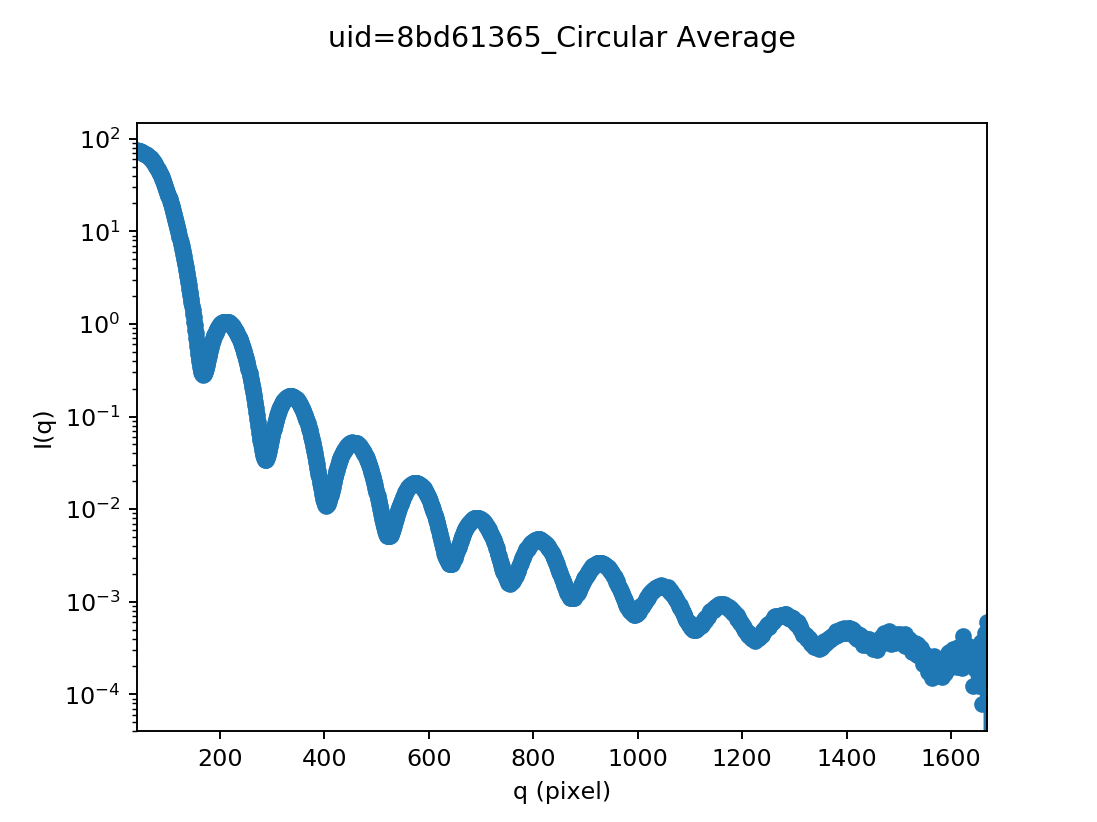

/nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/XPCS_SAXS.py:513: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_ylim(   ylim  )


In [29]:
if scat_geometry =='saxs':
    mask = mask_copy.copy()
    ## Get circular average| * Do plot and save q~iq
    hmask = create_hot_pixel_mask( avg_img, threshold = 1e9, center=center, center_radius=10)
    qp_saxs, iq_saxs, q_saxs = get_circular_average( avg_img*mask, mask * hmask, pargs=setup_pargs  )
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, show_pixel=True,
                      xlim=[qp_saxs.min(), qp_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )
    mask = np.array( mask * hmask, dtype=bool) 
    

<IPython.core.display.Javascript object>


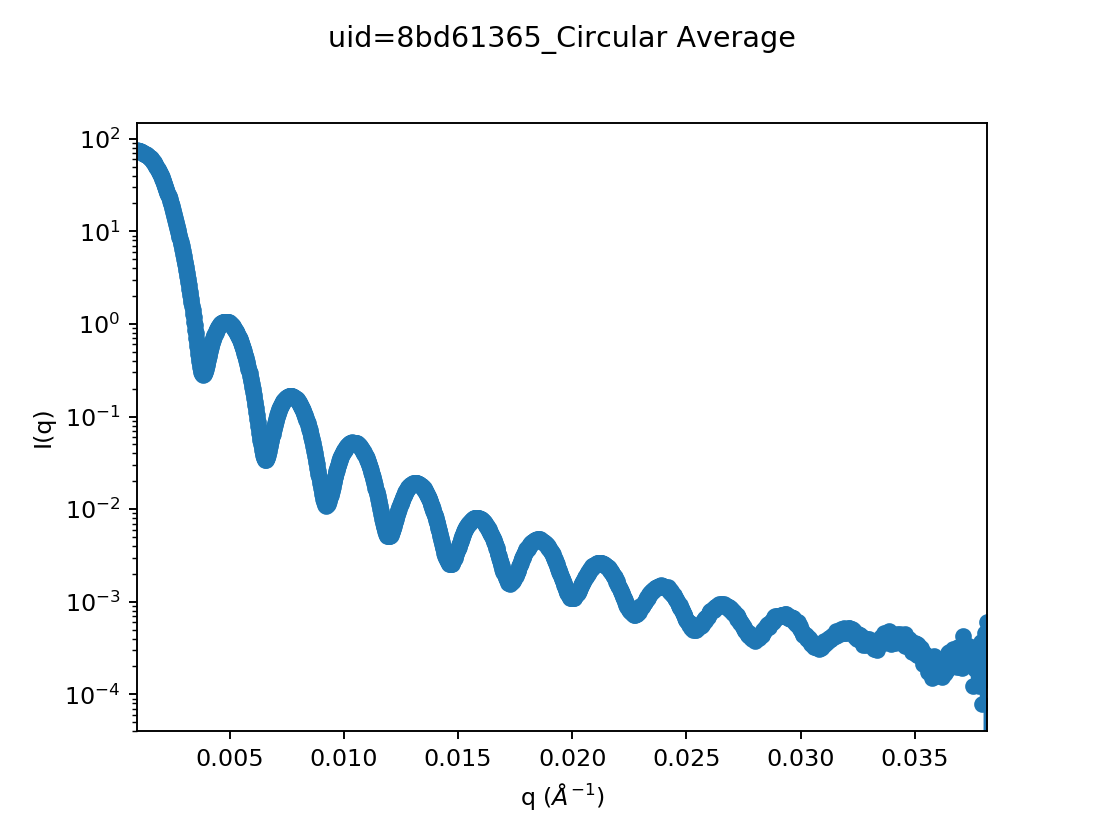

In [30]:
if scat_geometry =='saxs':   
    plot_circular_average( qp_saxs, iq_saxs, q_saxs,  pargs=setup_pargs, show_pixel=False,
                      xlim=[q_saxs.min(), q_saxs.max()*1.0], ylim = [iq_saxs.min(), iq_saxs.max()*2] )
    

In [31]:
#from pyCHX.chx_generic_functions import get_touched_qwidth

In [32]:
if scat_geometry =='saxs':    
    uniformq =    False #True #False    
    ## Define ROI
    #* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
    #* Create ring mask defined by  edges (all in pixel unit)    
    ### Define a non-uniform distributed rings by giving edges
    if not uniformq:  
        qcenters = np.array([ 0.0015, 0.00241,  0.00332,    0.004872, 0.005775,   0.0076 ] )
        width = 0.0009   
        
        qcenters = np.array([ 0.00241, 0.0037, 0.005, 0.00667,  0.0077, 0.0094, 
                            0.011, 0.0123, 0.0136,0.0155,0.0165, 0.0178,
                             0.0197, 0.021, 0.0224,0.0251 
                            ] )  # for 450 ?
        
        
        qcenters = np.array([ 0.0015, 0.00241,  0.00332,    0.004872, 0.005775,   0.0076, 0.0105, 0.0132 ] )
            
        #width =  [ i for i in np.diff( np.array(qcenters) ) *.9] + [ 0.0011]    
        width = get_touched_qwidth( qcenters ) 
        
        edges = get_non_uniform_edges(  qcenters, width, number_rings =1 )    
        inner_radius= None
        outer_radius = None
        width = None
        num_rings = None        
    # Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)
    if uniformq:            
        inner_radius=  0.002  #0.0015 #0.002  #0.0018
        outer_radius = 0.029 #0.0108 #0.015  # 0.024 #0.05 # 0.0274 #0.05
        num_rings = 16 #18
        gap_ring_number = 40 # 40 #1 #40 #1#40 #40 #1
        width =    ( outer_radius - inner_radius)/(num_rings + gap_ring_number)
        edges = None
        
        if (inner_radius<=q_saxs.min()) or   (outer_radius>=q_saxs.max()):
            print('Warning:\nThe inner_radius is smaller than the min of Q.Or the outer_radius is larger than the max of Q. Please Check!')
            print('However, our code will remove the bad qs.')                                

8


<IPython.core.display.Javascript object>


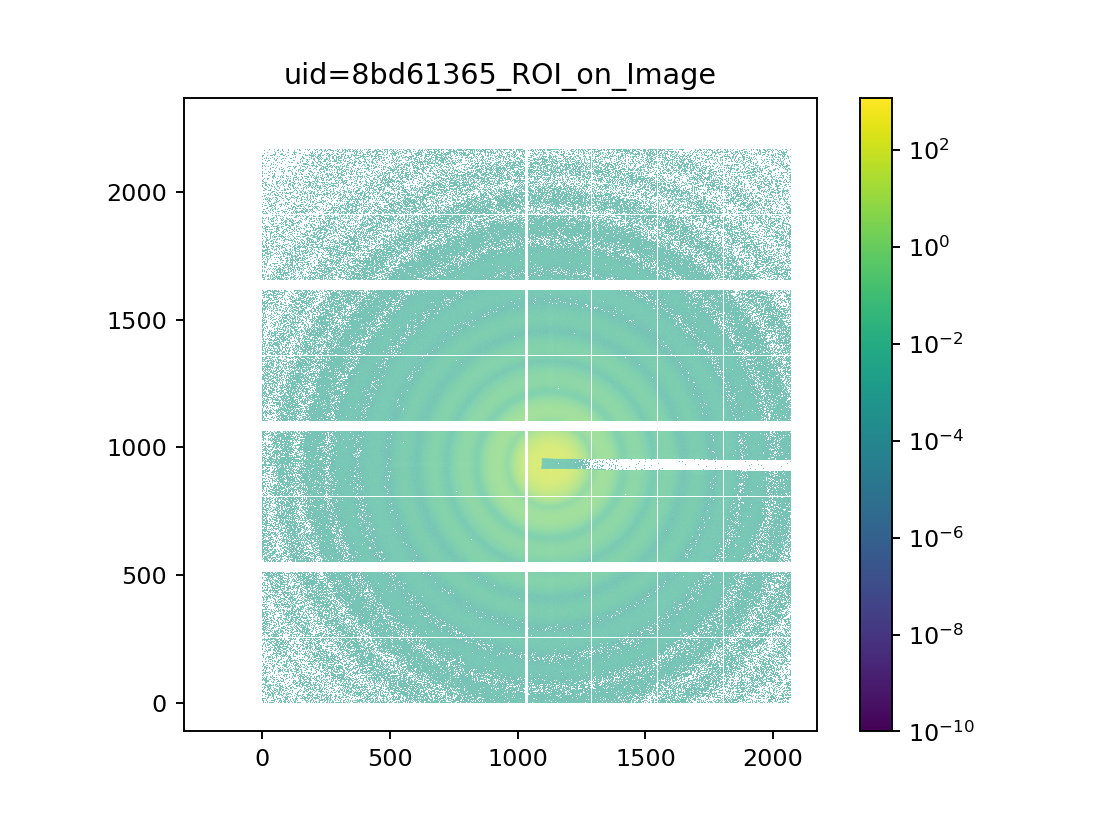

In [33]:
if scat_geometry =='saxs':
    roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )
    qind, pixelist = roi.extract_label_indices(  roi_mask  ) 
    qr = np.round( qr, 5)
    qr = qr[(qr+np.diff(qr_edge)[0]>=q_saxs.min()) &  (qr-np.diff(qr_edge)[-1]<=q_saxs.max())]
    noqs = len(np.unique(qind))
    nopr = np.bincount(qind, minlength=(noqs+1))[1:]    

    #if md['detector'] =='eiger500K_single_image':
    #    qmax = 0.0285
    #    qr = qr[qr < qmax]
    
    print(len(qr))
    show_ROI_on_image( avg_img, roi_mask, center[::-1], label_on = False,
                rwidth = 1240, alpha=.4,  
                save=True, path=data_dir, uid=uidstr, vmin= np.min(avg_img), vmax= np.max(avg_img),
                     aspect=1) 
    qval_dict = get_qval_dict( np.round(qr, 5)  ) 

<IPython.core.display.Javascript object>


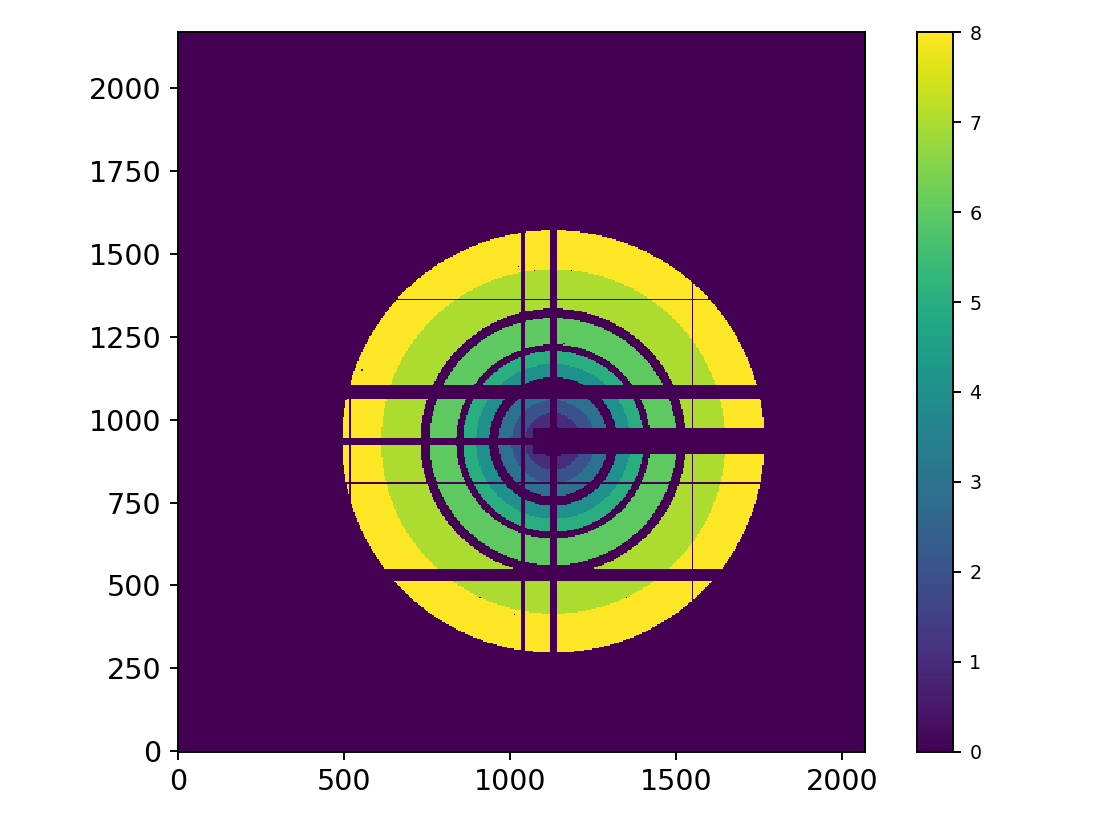

In [34]:
show_img(roi_mask, aspect=1)

In [35]:
#show_img( roi_mask,  vmin=-1, vmax= 12,   image_name= uidstr + '_roi_mask')

<IPython.core.display.Javascript object>


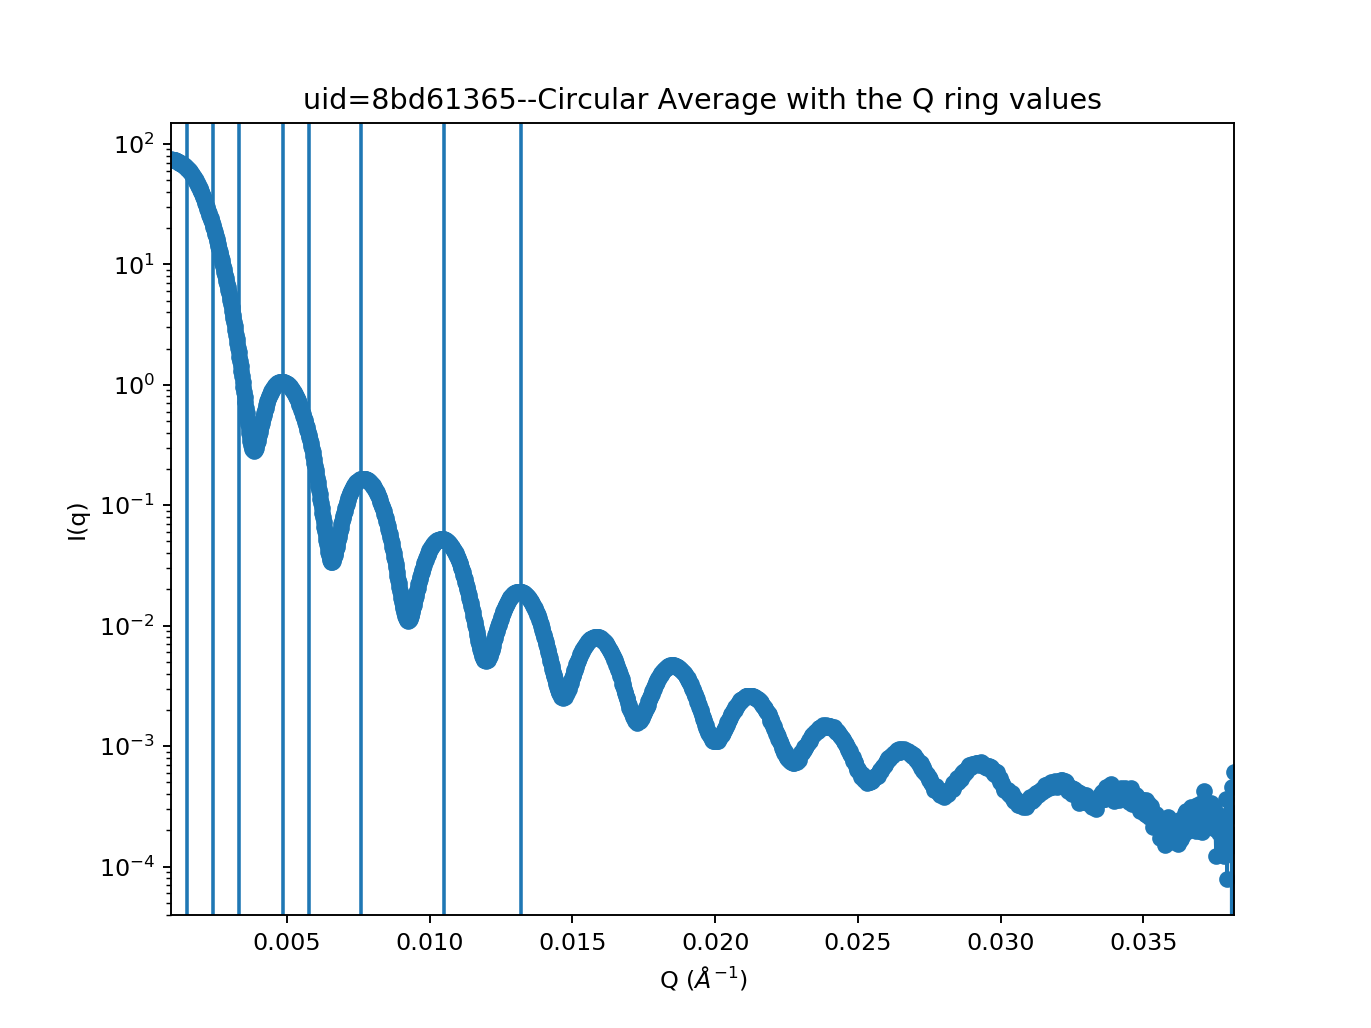

/nsls2/xf11id1/analysis/Analysis_Pipelines/Develop/pyCHX/pyCHX/XPCS_SAXS.py:1495: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axes.set_ylim(   ylim  )


In [36]:
if scat_geometry =='saxs':
    plot_qIq_with_ROI( q_saxs, iq_saxs, qr, logs=True, uid=uidstr, 
                      xlim= [q_saxs.min(), q_saxs.max()],
                  ylim = [iq_saxs.min(), iq_saxs.max()*2],  save=True, path=data_dir)

In [37]:
qphi_analysis = False #False #True#False #True
flow = False #True 
print( qphi_analysis, flow)

#qphi_analysis = True #False #True#False #True
#flow = True #False #True 
 
print( qphi_analysis, flow)

False False
False False


In [38]:
if scat_geometry =='saxs':
    if qphi_analysis:     
        roi_mask, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
            outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                          unit='A',       pargs=setup_pargs   )    
        # define q-mask
        if False:#if True, redefine qcenters
            qcenters = [  0.0023,  0.00365, 0.0050, 0.00621, 0.00754, 0.00880  ] #in A-1        
            #width = 0.0001  # in A-1         
            #width =    [0.0001,      0.00012,  0.00014,  0.00016, 0.00018,  0.0002,  0.00022 ]
            width =    np.array( [0.0001,      0.00012,  0.00014,  0.00016, 0.00018,  0.0002,  0.00022 ] ) * 3.5

            edges = get_non_uniform_edges(  qcenters, width, number_rings=1 )    
            inner_radius= None
            outer_radius = None
            width = None
            num_rings = None         
            roi_mask_qr, qr, qr_edge = get_ring_mask(  mask, inner_radius=inner_radius, 
                    outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges,
                              unit='A',       pargs=setup_pargs   )
        else:#use the pre-defined qr mask
            roi_mask_qr  =  roi_mask 
        # define angle-mask        
        ang_centers = np.array([0,90,180,270])-180        
        ang_width = np.array([10,10,10,10]) * 4
        
        #ang_centers = np.array([0,30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330 ])-180        
        #ang_width = 30 -.1     
        
        
        ang_edges = get_non_uniform_edges(  ang_centers, ang_width, number_rings=1 )    
        inner_angle= None
        outer_angle = None
        ang_width = None    
        num_angles = None

        
        if flow: #For flow geometry, 
            #please only define a quarter ROI from around flow_angle-90 to around the flow angle
            flow_angle = 90
            ang_edges = roi.ring_edges( -10, 20, 2.5, 5) 
        
        roi_mask_ang, ang_center, ang_edge = get_angular_mask( mask,  inner_angle= inner_angle, 
                outer_angle = outer_angle, width = ang_width, edges = ang_edges,
                num_angles = num_angles, center = center, flow_geometry= flow, flow_angle=flow_angle ) 

        
        roi_mask, good_ind = combine_two_roi_mask( roi_mask_qr, roi_mask_ang,pixel_num_thres=100)   
        qval_dict_ = get_qval_dict(  qr_center = qr, qz_center = ang_center,one_qz_multi_qr=False)
        qval_dict = {  i:qval_dict_[k] for (i,k) in enumerate( good_ind) }
        
        show_ROI_on_image( avg_img*mask, roi_mask, center, label_on = True, rwidth = 840, alpha=.9,  
                 save=True, path=data_dir, uid=uidstr, vmin= 1e-3,
                 vmax= 1e3, #np.max(avg_img),
                 aspect=1,
                 show_roi_edge=True,
                 show_ang_cor = True) 

<IPython.core.display.Javascript object>


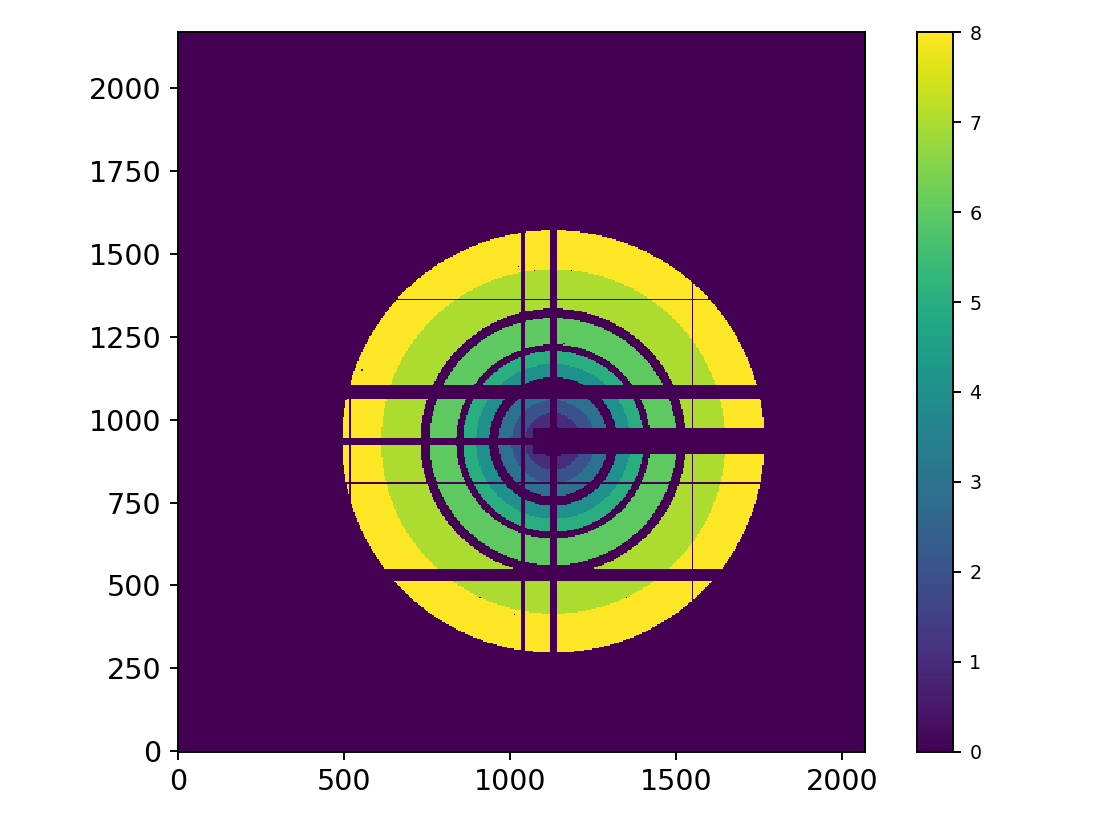

In [39]:
show_img(roi_mask, aspect=1)

In [40]:
#plt.figure()
#plt.imshow( roi_mask_ang )

# WAXS Geometry

In [41]:
def create_ellipse_donut(  cx, cy , wx_inner, wy_inner, wx_outer, wy_outer, roi_mask, gap=0):
    Nmax = np.max( np.unique( roi_mask ) )
    rr1, cc1 = ellipse( cy,cx,  wy_inner, wx_inner  )    
    rr2, cc2 = ellipse( cy, cx,  wy_inner + gap, wx_inner +gap ) 
    rr3, cc3 = ellipse( cy, cx,  wy_outer,wx_outer ) 
    roi_mask[rr3,cc3] = 2 + Nmax
    roi_mask[rr2,cc2] = 0
    roi_mask[rr1,cc1] = 1 + Nmax
    return roi_mask
    
def create_box( cx, cy, wx, wy, roi_mask):
    Nmax = np.max( np.unique( roi_mask ) )
    for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
        x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
        y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
        rr, cc = polygon( y,x)         
        roi_mask[rr,cc] = i +1 + Nmax
    return roi_mask


In [42]:
if scat_geometry =='gi_waxs':
    #box_roi = True
    single_box = False   #True, if True, the roi is one box, else, roi is multi-boxes
    ellipse_roi = True
    
    if box_roi:
        if not single_box:
            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [20,10]  #each box width and height

            cx = np.int_(np.linspace( 55, 955, 10))  #box center-x        
            nx = len(cx)//2

            y1 = 760-8
            y2=  780-8
            cy1 = np.linspace( y1, y2, nx)
            cy2 = np.linspace( y2, y1, nx)


            cy = np.int_( np.concatenate( [cy1, cy2] ) )  #box-center y

            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1
            roi_mask = roi_mask * mask  
            
        else:

            roi_mask = np.zeros_like( avg_img , dtype = np.int32)
            wx,wy = [40,20]  #each box width and height    
            cx, cy = [[ 184, 817, 200, 800], [ 637, 637,200, 200]]     
            cx, cy = [[ 160, 817, 200, 800], [ 650, 637,200, 200]]    
            for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                rr, cc = polygon( y,x)
                #print( i + 1  )
                roi_mask[rr,cc] = i +1

            if False:
                Nmax = np.max( np.unique( roi_mask ) )
                print( Nmax)
                wx,wy = [30,10]  #each box width and height    
                cx, cy = [[ 44, 80], [ 725, 725]]     
                for i, [cx_,cy_] in enumerate(list( zip( cx,cy  ))):  #create boxes
                    x = np.array( [ cx_-wx, cx_+wx,  cx_+wx, cx_-wx])  
                    y = np.array( [ cy_-wy, cy_-wy, cy_+wy, cy_+wy])
                    rr, cc = polygon( y,x)
                    #print( i + 1  )
                    roi_mask[rr,cc] = i +1 + Nmax
        
        
    if ellipse_roi:
        #define donut shapes here
        roi_mask = np.zeros_like( avg_img , dtype = np.int32)
        #wx1,wy1 = [109, 791]  #inner ellipse width and height    
        #wx2,wy2 = [80,40]  #outer ellipse width and height 
        #gap=5        #gap between two ellipse
        #cx, cy = [[ 184, 817, 200, 800], [ 637, 637,200, 200]] 
        wx_inner, wy_inner = 40, 20
        
        CY = 800
        Nmax=0
        for CYI in [180, 120, 60, 0, -60, -120, -180]:
            cx, cy = [    [70 + 90 *i for i in range(11)]   , [ CY + CYI +i*0 for i in range(11)]]
            for i, [x,y] in enumerate(list( zip( cx,cy  ))):  #create ellipse            
                rr, cc = ellipse( y,x,  wy_inner, wx_inner  )  
                roi_mask[rr,cc] = i +1+Nmax
            Nmax = np.max( np.unique( roi_mask ) )         
        
 
             
    #define one box here
    #wx,wy = [40,15]  #each box width and height    
    #cx, cy = [[ 510], [ 880]]  
    #roi_mask = create_box( cx, cy, wx, wy, roi_mask)

        
    roi_mask = roi_mask * mask  
    qind, pixelist = roi.extract_label_indices(roi_mask)
    noqs = len(np.unique(qind))
    qval_dict = get_qval_dict(   1 + np.arange(noqs)   ) 

<IPython.core.display.Javascript object>


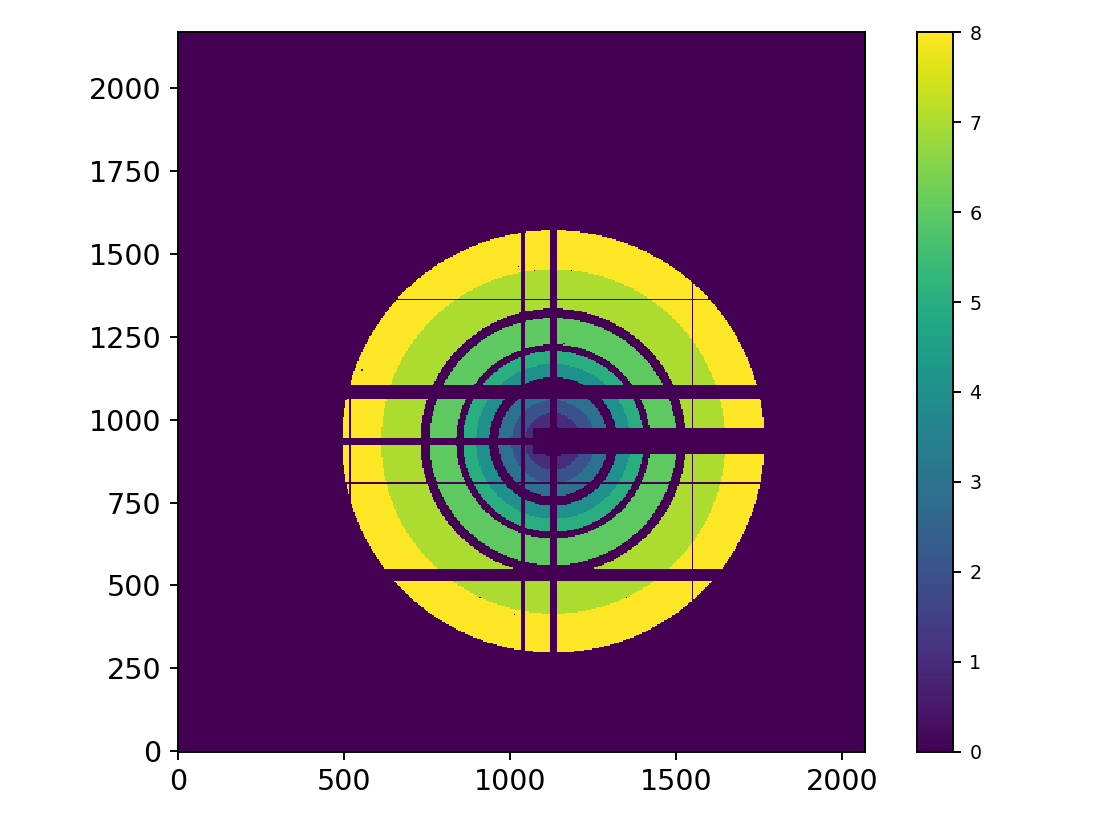

In [43]:
show_img(roi_mask, aspect=1)

In [44]:
#%run ~/pyCHX_link/pyCHX/chx_generic_functions.py

In [45]:
if scat_geometry =='gi_waxs':
    #badpixel = np.where( avg_img[:600,:] >=300 )
    #roi_mask[badpixel] = 0
    show_ROI_on_image( avg_img, roi_mask, label_on = True,  alpha=.1, show_roi_edge=True,
                 save=True, path=data_dir, uid=uidstr, vmin=0.1, vmax=1e4, cmap = cmap_albula)

# GiSAXS Scattering Geometry

In [46]:
setup_pargs 

{'uid': 'uid=8bd61365',
 'dpix': 0.07500000356230885,
 'Ldet': 16035.699844360352,
 'lambda_': 1.2846771,
 'exposuretime': 0.0013340212,
 'timeperframe': 0.00134,
 'center': [933, 1128],
 'path': '/XF11ID/analysis/2019_3/yuzhang/Results/8bd61365/'}

In [47]:
if scat_geometry =='gi_saxs':
    # Get Q-Map (Qz and Qr)
    ### Users defined incident-Beam and Reflection_Beam Centers at the begining!!!
    alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Ldet )
    qx_map, qy_map, qr_map, qz_map = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lambda_, Lsd=Ldet )
    ticks_  = get_qzr_map(  qr_map, qz_map, inc_x0, Nzline=10,  Nrline=10   )
    ticks = ticks_[:4]
    plot_qzr_map(  qr_map, qz_map, inc_x0, ticks = ticks_, data= avg_img, uid= uidstr, path = data_dir   )

## Static Analysis for gisaxs

In [48]:
if scat_geometry =='gi_saxs':
    # For diffuse near Yoneda wing
    
    qz_start = 0.03  # was 0.046
    qz_end = 0.05
    qz_num= 1
    qz_width = 0.001

    qr_start =  0.001
    qr_end = 0.03
    qr_num = 1
    qr_width = 0.08  


    Qrs = [qr_start , qr_end, qr_width, qr_num]
    Qzs=  [qz_start,   qz_end,  qz_width , qz_num ]

    # Don't Change these lines below here
    roi_masks, qval_dicts = get_gisaxs_roi( Qrs, Qzs, qr_map, qz_map, mask= mask )
    show_qzr_roi( avg_img, roi_masks, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )


## Dynamic Analysis for gi_saxs

In [49]:
if scat_geometry =='gi_saxs':
    # Define Q-ROI
    #* Users provide the interested Qz and Qr here for XPCS analysis, e.g., qr start/end/number/width et.al
    # Change these lines

    qz_start = 0.03  # was 0.046
    qz_end = 0.04
    qz_num= 3
    qz_width = 0.0025

    qr_start =  0.001
    qr_end = 0.02
    qr_num = 6
    qr_width = 0.003  
    
    
    print('qr_end = ', qr_end)
    
    Qr = [qr_start , qr_end, qr_width, qr_num]
    Qz=  [qz_start,   qz_end,  qz_width , qz_num ]
    # Don't Change these lines below here
    roi_mask, qval_dict = get_gisaxs_roi( Qr, Qz, qr_map, qz_map, mask= mask )


In [50]:
if scat_geometry =='gi_saxs':
    ### Change the below lines to if define another ROI, if define even more, just repeat this process
    define_second_roi = True  #if True to define another line; else: make it False
    if define_second_roi:    
        qval_dict1 = qval_dict.copy()
        roi_mask1 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Second ROI
    if define_second_roi:    
        qz_start2 = 0.06
        qz_num2= 1
        qz_width2 = 0.002   
        
        qz_end2 = qz_start2 + qz_num2*qz_width2
        
        qr_start2 =  0.00
        qr_width2 = 0.001
        qr_num2 = 1
    
        qr_end2 = qr_start2 + qr_num2*qr_width2
        print(qr_end2)
        
        Qr2 = [qr_start2 , qr_end2, qr_width2, qr_num2]
        Qz2=  [qz_start2,   qz_end2,  qz_width2 , qz_num2 ] 
        roi_mask2, qval_dict2 = get_gisaxs_roi( Qr2, Qz2, qr_map, qz_map, mask= mask )
        
        qval_dict = update_qval_dict(  qval_dict1, qval_dict2 )
        roi_mask = update_roi_mask(  roi_mask1, roi_mask2 )  
        
    ### Third ROI
    define_third_roi =  False  #if True to define another line; else: make it False
    if define_third_roi:    
        qval_dict2 = qval_dict.copy()
        roi_mask2 = roi_mask.copy()
        del qval_dict, roi_mask
    ## The Third ROI
    if define_third_roi:    
        qz_start3 = 0.06
        qz_num3= 1
        qz_width3 = 0.008
        
        qz_end3 = qz_start3 + qz_num3*qz_width3
        
        qr_start3 = 0.0001
        qr_end3 = 0.001
        qr_num3 = 1
        gap_qr_num3 = 1
        qr_width3 = 0.001 #( qr_end2- qr_start2)/(qr_num2+gap_qr_num2)        
        
        Qr3 = [qr_start3 , qr_end3, qr_width3, qr_num3]
        Qz3=  [qz_start3,   qz_end3,  qz_width3 , qz_num3 ] 
        roi_mask3, qval_dict3 = get_gisaxs_roi( Qr3, Qz3, qr_map, qz_map, mask= mask )
        
        qval_dict = update_qval_dict(  qval_dict2, qval_dict3 )
        roi_mask = update_roi_mask(  roi_mask2, roi_mask3 )    
        
        
        
    show_qzr_roi( avg_img, roi_mask, inc_x0, ticks, alpha=0.5, save=True, path=data_dir, uid=uidstr )        
    ## Get 1D Curve (Q||-intensity¶)
    qr_1d_pds = cal_1d_qr( avg_img, Qr, Qz, qr_map, qz_map, inc_x0= None, setup_pargs=setup_pargs )
    plot_qr_1d_with_ROI( qr_1d_pds, qr_center=np.unique( np.array(list( qval_dict.values() ) )[:,0] ),
                    loglog=True, save=True, uid=uidstr, path = data_dir)

## Examine the created roi-mask

In [51]:
qind, pixelist = roi.extract_label_indices(roi_mask)
noqs = len(np.unique(qind))
print(noqs)
nopr = np.bincount(qind, minlength=(noqs+1))[1:]
print(nopr)

8
[  9095  18903  24678  41258  51573 144825 284015 381460]


# Refine the roi_mask by masking bad pixels

<IPython.core.display.Javascript object>


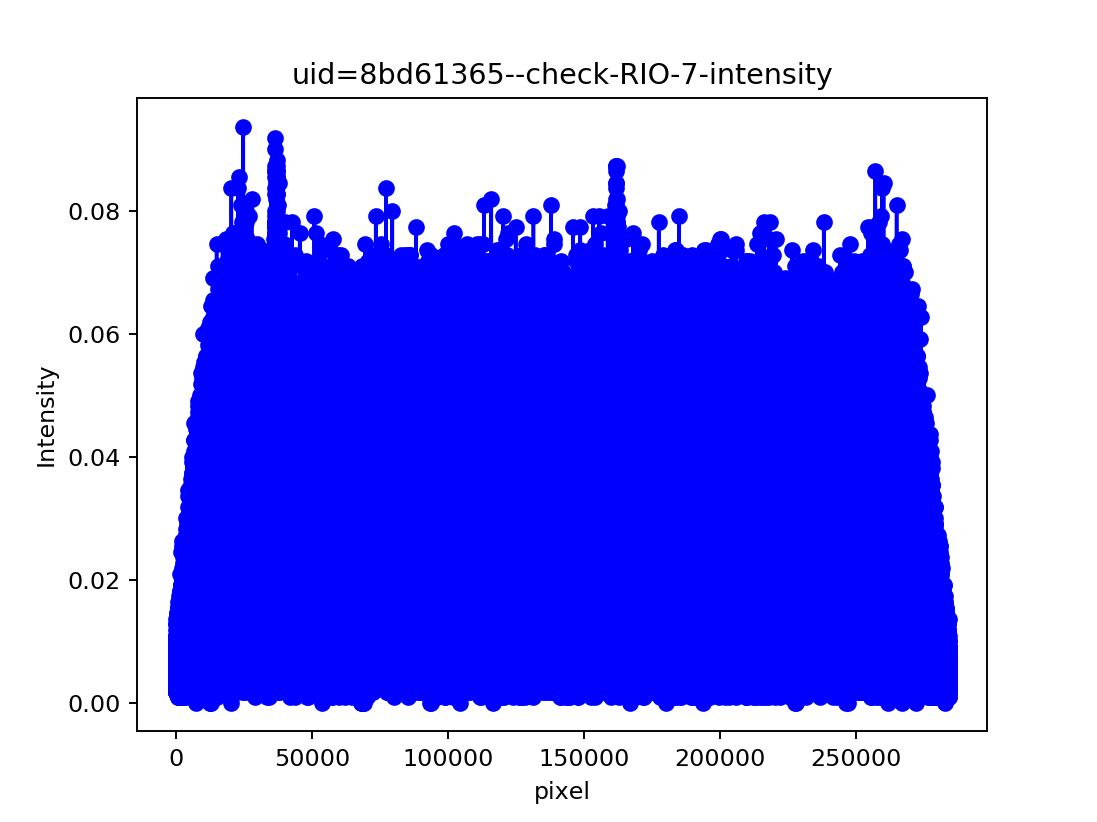

In [52]:
roi_mask_copy = roi_mask.copy()
qint =  7  #starting from 1
roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

In [53]:
refine_roi = False

In [54]:
Nq = len( np.unique(roi_mask))-1

In [55]:
if refine_roi:
#if scat_geometry =='saxs':    
    roi_mask = roi_mask_copy
    filter_badpix_dict ={}
    for k in range(1, Nq +1 ):
        roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number=k, uid =uidstr, plot=False )    
        bad_pix_list=  get_bad_frame_list( roi_inten, fit=True, polyfit_order = 30, 
            scale= 3.5,  good_start = None, good_end= None, uid= uidstr, path=data_dir, plot=False)
        print( 'The bad frame list length is: %s'%len(bad_pix_list ) )
        filter_badpix_dict[k] = bad_pix_list

In [56]:
if refine_roi:
#if scat_geometry =='saxs':
    roi_mask = filter_roi_mask( filter_badpix_dict, roi_mask, avg_img, filter_type = 'badpix' )
    roi_inten = check_ROI_intensity( avg_img, roi_mask, ring_number= qint, uid =uidstr )

In [57]:
path

'/XF11ID/analysis/2019_3/masks/'

In [58]:
#show_img(roi_mask )

In [59]:
fp = path + 'uid=%s_roi_mask.pkl'%uid
cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )
print(fp)
if scat_geometry == 'saxs':  
    if qphi_analysis:
        cpk.dump( [roi_mask_qr,qval_dict],  open( fp[:-4] +'_qr.pkl' , 'wb' ) )
        print('The Qr-ROI is also saved as %s due to doing phi-analysis.'%(fp[:-4] +'_qr.pkl'))

##save with a meaningful filename, make False after excute to avoid over-write
#if True:    
if False:
    date = 'June26_250'
    #fp=path + 'roi_mask_%s_4M_wide.pkl'%date    
    fp=path + 'roi_mask_%s_4M_norm.pkl'%date 
    #fp=path + 'roi_mask_%s_4M_phi_4x_20deg.pkl'%date 
    #fp=path + 'roi_mask_%s_4M_flow.pkl'%date     

    
    #fp=path + 'roi_mask_%s_500K_wide.pkl'%date  
    #fp=path + 'roi_mask_%s_500K_norm.pkl'%date  
    #fp=path + 'roi_mask_%s_500K_phi_4x_20deg.pkl'%date  
    
    cpk.dump( [roi_mask,qval_dict],  open(fp, 'wb' ) )
    print(fp)



#roi_mask,qval_dict = cpk.load( open(fp, 'rb' )  )  #for load the saved roi data


/XF11ID/analysis/2019_3/masks/uid=8bd61365_roi_mask.pkl


In [60]:
if scat_geometry == 'gi_saxs':    
    
    fp = path + 'uid=%s_roi_masks.pkl'%uid
    cpk.dump( [roi_masks,qval_dicts],  open(fp, 'wb' ) )
    print(fp)
    ##save with a meaningful filename, make False after excute to avoid over-write
    fp = path + 'uid=%s_qmap.pkl'%uid    #dump qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0
    print(fp)
    cpk.dump( [qr_map, qz_map, ticks_, Qrs, Qzs, Qr, Qz, inc_x0, refl_x0, refl_y0 ],  open(fp, 'wb' ) )

        


In [61]:
username

'yuzhang'